# Build a Question Answering application over a Graph Database

Used this tutorial: https://python.langchain.com/docs/tutorials/graph/


In [1]:
%pip install --upgrade --quiet langchain langchain-neo4j langchain-openai langgraph python-dotenv



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Graph schema

In order for an LLM to be able to generate a Cypher statement, it needs information about the graph schema. 

In [1]:
import getpass
import os
from dotenv import load_dotenv
from langchain_neo4j import Neo4jGraph

graph_with_schema = Neo4jGraph(
    url=os.getenv("NEO4J_URI"),
    username=os.getenv("NEO4J_USERNAME"),
    password=os.getenv("NEO4J_PASSWORD"),
    enhanced_schema=False
)
graph_with_schema.refresh_schema()

print(graph_with_schema.schema)

Node properties:
DISEASE {Disease_ID: STRING, Name: STRING, Description: STRING}
MOLECULE {CHEMBL_ID: STRING, Name: STRING, Synonym_Names: STRING, Canonical_Smiles: STRING, Drug_Type: STRING, Description: STRING, embedding: LIST, Cross_Reference_Names: STRING, Max_Clinicial_Trial_Phase: STRING, is_Approved: STRING}
TARGET {Target_ID: STRING, Name: STRING, Symbol: STRING, Biological_Type: STRING}
Chunk {id: STRING, text: STRING, question: STRING, query: STRING, embedding: LIST}
Relationship properties:
chemblDrugToTarget {datasourceId: STRING, score: STRING, clinicalPhase: STRING, clinicalStatus: STRING, studyId: STRING, urls: STRING, variantEffect: STRING, directionOnTrait: STRING}
Known_Molecule_Link_To_Disease {score: STRING}
Known_Molecule_Link_To_Target {score: STRING}
cancer_biomarkersDrugToTarget {datasourceId: STRING, score: STRING, literature: STRING, biomarkerName: STRING, confidence: STRING, drugResponse: STRING}
chemblDiseaseToTarget {datasourceId: STRING, score: STRING, cli

## Advanced implementation with LangGraph

Here is the visualized LangGraph flow we will implement:

![langgraph_text2cypher](https://github.com/langchain-ai/langchain/blob/master/docs/static/img/langgraph_text2cypher.webp?raw=1)


In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)


We will begin by defining the Input, Output, and Overall state of the LangGraph application.

In [3]:
from operator import add
from typing import Annotated, List

from typing_extensions import TypedDict


class InputState(TypedDict):
    question: str


class OverallState(TypedDict):
    question: str
    next_action: str
    cypher_statement: str
    cypher_errors: List[str]
    database_records: List[dict]
    steps: Annotated[List[str], add]


class OutputState(TypedDict):
    answer: str
    steps: List[str]
    cypher_statement: str

The first step is a simple `guardrails` step, where we validate whether the question pertains to genes, drugs, or targets. If it doesn't, we notify the user that we cannot answer any other questions. Otherwise, we move on to the Cypher generation step.

In [4]:
def reject_question(state: OverallState) -> OutputState:
    return {
        "answer": "Sorry, I can't answer questions unrelated to genes, drugs, or their targets.",
        "cypher_statement": "",
        "steps": state.get("steps", []) + ["rejected"],
    }

In [5]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

guardrails_system = """
As an intelligent assistant, your primary objective is to decide whether a given question is related to genes, drugs, and their targets.
If the question is related to genes, drugs, and their targets, output "drug". Otherwise, output "end".
To make this decision, assess the content of the question and determine if it refers to any genes, drugs, targets,
or related topics. Provide only the specified output: "drug" or "end".
"""
guardrails_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            guardrails_system,
        ),
        (
            "human",
            ("{question}"),
        ),
    ]
)


class GuardrailsOutput(BaseModel):
    decision: Literal["drug", "end"] = Field(
        description="Decision on whether the question is related to genes, drugs, and their targets"
    )


guardrails_chain = guardrails_prompt | llm.with_structured_output(GuardrailsOutput)


def guardrails(state: InputState) -> OverallState:
    """
    Decides if the question is related to genes, drugs, and their targets or not.
    """
    guardrails_output = guardrails_chain.invoke({"question": state.get("question")})
    database_records = None
    if guardrails_output.decision == "end":
        database_records = "This questions is not about genes, drugs, and their targets. Therefore I cannot answer this question."
    return {
        "next_action": guardrails_output.decision,
        "database_records": database_records,
        "steps": ["guardrail"],
    }

### Few-shot prompting

Converting natural language into accurate queries is challenging. One way to enhance this process is by providing relevant few-shot examples to guide the LLM in query generation. To achieve this, we will use the `SemanticSimilarityExampleSelector` to dynamically select the most relevant examples.

In [6]:
from langchain_core.example_selectors import SemanticSimilarityExampleSelector
from langchain_neo4j import Neo4jVector
from langchain_openai import OpenAIEmbeddings
import json 
with open('few_shot_prompts.json', 'r') as f:
    examples = json.load(f)

#For future: change k number of examples to use?
example_selector = SemanticSimilarityExampleSelector.from_examples(
    examples, OpenAIEmbeddings(), Neo4jVector, k=5, input_keys=["question"]
)

print(type(examples))
print(len(examples))

<class 'list'>
14


Next, we implement the Cypher generation chain, also known as **text2cypher**. The prompt includes a graph schema, dynamically selected few-shot examples, and the user’s question. This combination enables the generation of a Cypher query to retrieve relevant information from the database.

In [7]:
from langchain_core.output_parsers import StrOutputParser

text2cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "Given an input question, convert it to a Cypher query. No pre-amble."
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        ),
        (
            "human",
            (
                """You are a Neo4j expert. Given an input question, create a syntactically correct Cypher query to run.
Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!
Here is the schema information. It is important to know that there is also an 'embedding' property on Molecules that is very useful 
and part of the schema.
{schema}

Below are a number of examples of questions and their corresponding Cypher queries. 
IMPORTANT: When the question asks for similar drugs or similarity search, you MUST use this exact Cypher pattern with the embedding property
on MOLECULE nodes:
CALL db.index.vector.queryNodes('molEmbed', 10, ref.embedding) 

{fewshot_examples}

User input: {question}
Cypher query:"""
            ),
        ),
    ]
)

text2cypher_chain = text2cypher_prompt | llm | StrOutputParser()


def generate_cypher(state: OverallState) -> OverallState:
    """
    Generates a cypher statement based on the provided schema and user input
    """
    NL = "\n"
    fewshot_examples = (NL * 2).join(
        [
            f"Question: {el['question']}{NL}Cypher:{el['query']}"
            for el in example_selector.select_examples(
                {"question": state.get("question")}
            )
        ]
    )
    generated_cypher = text2cypher_chain.invoke(
        {
            "question": state.get("question"),
            "fewshot_examples": fewshot_examples,
            "schema": graph_with_schema.schema,
        }
    )
    return {"cypher_statement": generated_cypher, "steps": ["generate_cypher"]}

### Query validation

The next step is to validate the generated Cypher statement and ensuring that all property values are accurate. While numbers and dates typically don’t require validation, strings such as movie titles or people’s names do. In this example, we’ll use a basic `CONTAINS` clause for validation, though more advanced mapping and validation techniques can be implemented if needed.

First, we will create a chain that detects any errors in the Cypher statement and extracts the property values it references.

In [8]:
from typing import List, Optional

validate_cypher_system = """
You are a Cypher expert reviewing a statement written by a junior developer.
"""

validate_cypher_user = """You must check the following:
* Are there any syntax errors in the Cypher statement?
* Are there any missing or undefined variables in the Cypher statement?
* Are any node labels missing from the schema?
* Are any relationship types missing from the schema?
* Are any of the properties not included in the schema?
* Does the Cypher statement include enough information to answer the question?

Examples of good errors:
* Label (:Foo) does not exist, did you mean (:Bar)?
* Property bar does not exist for label Foo, did you mean baz?
* Relationship FOO does not exist, did you mean FOO_BAR?

Schema:
{schema}

The question is:
{question}

The Cypher statement is:
{cypher}

Make sure you don't make any mistakes!"""

validate_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            validate_cypher_system,
        ),
        (
            "human",
            (validate_cypher_user),
        ),
    ]
)


class Property(BaseModel):
    """
    Represents a filter condition based on a specific node property in a graph in a Cypher statement.
    """

    node_label: str = Field(
        description="The label of the node to which this property belongs."
    )
    property_key: str = Field(description="The key of the property being filtered.")
    property_value: str = Field(
        description="The value that the property is being matched against."
    )


class ValidateCypherOutput(BaseModel):
    """
    Represents the validation result of a Cypher query's output,
    including any errors and applied filters.
    """

    errors: Optional[List[str]] = Field(
        description="A list of syntax or semantical errors in the Cypher statement. Always explain the discrepancy between schema and Cypher statement"
    )
    filters: Optional[List[Property]] = Field(
        description="A list of property-based filters applied in the Cypher statement."
    )


validate_cypher_chain = validate_cypher_prompt | llm.with_structured_output(
    ValidateCypherOutput
)

LLMs often struggle with correctly determining relationship directions in generated Cypher statements. Since we have access to the schema, we can deterministically correct these directions using the **CypherQueryCorrector**.

*Note: The `CypherQueryCorrector` is an experimental feature and doesn't support all the newest Cypher syntax.*

In [9]:
from langchain_neo4j.chains.graph_qa.cypher_utils import CypherQueryCorrector, Schema

# Cypher query corrector is experimental
corrector_schema = [
    Schema(el["start"], el["type"], el["end"])
    for el in graph_with_schema.structured_schema.get("relationships")
]
cypher_query_corrector = CypherQueryCorrector(corrector_schema)

Now we can implement the Cypher validation step. First, we use the `EXPLAIN` method to detect any syntax errors. Next, we leverage the LLM to identify potential issues and extract the properties used for filtering. For string properties, we validate them against the database using a simple `CONTAINS` clause.

Based on the validation results, the process can take the following paths:

- If value mapping fails, we end the conversation and inform the user that we couldn't identify a specific property value (e.g., a person or movie title).  
- If errors are found, we route the query for correction.  
- If no issues are detected, we proceed to the Cypher execution step.  

In [10]:
from neo4j.exceptions import CypherSyntaxError


def validate_cypher(state: OverallState) -> OverallState:
    """
    Validates the Cypher statements and maps any property values to the database.
    """
    errors = []
    mapping_errors = []
    # Check for syntax errors
    try:
        graph_with_schema.query(f"EXPLAIN {state.get('cypher_statement')}")
    except CypherSyntaxError as e:
        errors.append(e.message)
    # Experimental feature for correcting relationship directions
    corrected_cypher = cypher_query_corrector(state.get("cypher_statement"))
    if not corrected_cypher:
        errors.append("The generated Cypher statement doesn't fit the graph schema")
    if not corrected_cypher == state.get("cypher_statement"):
        print("Relationship direction was corrected")
    # Use LLM to find additional potential errors and get the mapping for values
    llm_output = validate_cypher_chain.invoke(
        {
            "question": state.get("question"),
            "schema": graph_with_schema.schema,
            "cypher": state.get("cypher_statement"),
        }
    )
    if llm_output.errors:
        errors.extend(llm_output.errors)
    if llm_output.filters:
        for filter in llm_output.filters:
            # Do mapping only for string values
            if (
                not [
                    prop
                    for prop in graph_with_schema.structured_schema["node_props"][
                        filter.node_label
                    ]
                    if prop["property"] == filter.property_key
                ][0]["type"]
                == "STRING"
            ):
                continue
            mapping = graph_with_schema.query(
                f"MATCH (n:{filter.node_label}) WHERE toLower(n.`{filter.property_key}`) = toLower($value) RETURN 'yes' LIMIT 1",
                {"value": filter.property_value},
            )
            if not mapping:
                print(
                    f"Missing value mapping for {filter.node_label} on property {filter.property_key} with value {filter.property_value}"
                )
                mapping_errors.append(
                    f"Missing value mapping for {filter.node_label} on property {filter.property_key} with value {filter.property_value}"
                )
    if mapping_errors:
        next_action = "end"
    elif errors:
        next_action = "correct_cypher"
    else:
        next_action = "execute_cypher"

    return {
        "next_action": next_action,
        "cypher_statement": corrected_cypher,
        "cypher_errors": errors,
        "steps": ["validate_cypher"],
    }

The Cypher correction step takes the existing Cypher statement, any identified errors, and the original question to generate a corrected version of the query.

In [11]:
correct_cypher_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            (
                "You are a Cypher expert reviewing a statement written by a junior developer. "
                "You need to correct the Cypher statement based on the provided errors. No pre-amble."
                "Do not wrap the response in any backticks or anything else. Respond with a Cypher statement only!"
            ),
        ),
        (
            "human",
            (
                """Check for invalid syntax or semantics and return a corrected Cypher statement.

Schema:
{schema}

Note: Do not include any explanations or apologies in your responses.
Do not wrap the response in any backticks or anything else.
Respond with a Cypher statement only!

Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.

The question is:
{question}

The Cypher statement is:
{cypher}

The errors are:
{errors}

Corrected Cypher statement: """
            ),
        ),
    ]
)

correct_cypher_chain = correct_cypher_prompt | llm | StrOutputParser()


def correct_cypher(state: OverallState) -> OverallState:
    """
    Correct the Cypher statement based on the provided errors.
    """
    corrected_cypher = correct_cypher_chain.invoke(
        {
            "question": state.get("question"),
            "errors": state.get("cypher_errors"),
            "cypher": state.get("cypher_statement"),
            "schema": graph_with_schema.schema,
        }
    )

    return {
        "next_action": "validate_cypher",
        "cypher_statement": corrected_cypher,
        "steps": ["correct_cypher"],
    }

We need to add a step that executes the given Cypher statement. If no results are returned, we should explicitly handle this scenario, as leaving the context empty can sometimes lead to LLM hallucinations.

In [12]:
no_results = "I couldn't find any relevant information in the database"


def execute_cypher(state: OverallState) -> OverallState:
    """
    Executes the given Cypher statement.
    """
    print("Cypher to run:", state.get("cypher_statement"))
    records = graph_with_schema.query(state.get("cypher_statement"))
    return {
        "database_records": records if records else no_results,
        "next_action": "end",
        "steps": ["execute_cypher"],
    }

The final step is to generate the answer. This involves combining the initial question with the database output to produce a relevant response.

In [13]:
generate_final_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a helpful assistant",
        ),
        (
            "human",
            (
                """Use the following results retrieved from a database to provide
a succinct, definitive answer to the user's question.

Respond as if you are answering the question directly.

Results: {results}
Question: {question}"""
            ),
        ),
    ]
)

generate_final_chain = generate_final_prompt | llm | StrOutputParser()


def generate_final_answer(state: OverallState) -> OutputState:
    """
    Decides if the question is related to genes, drugs, or their targets.
    """
    final_answer = generate_final_chain.invoke(
        {"question": state.get("question"), "results": state.get("database_records")}
    )
    return {"answer": final_answer, "steps": ["generate_final_answer"]}

Next, we will implement the LangGraph workflow, starting with defining the conditional edge functions.

In [14]:
def guardrails_condition(
    state: OverallState,
) -> Literal["generate_cypher", "reject_question"]:
    if state.get("next_action") == "end":
        return "reject_question"
    elif state.get("next_action") == "drug":
        return "generate_cypher"


def validate_cypher_condition(
    state: OverallState,
) -> Literal["generate_final_answer", "correct_cypher", "execute_cypher"]:
    if state.get("next_action") == "end":
        return "generate_final_answer"
    elif state.get("next_action") == "correct_cypher":
        return "correct_cypher"
    elif state.get("next_action") == "execute_cypher":
        return "execute_cypher"

Let's put it all together now.

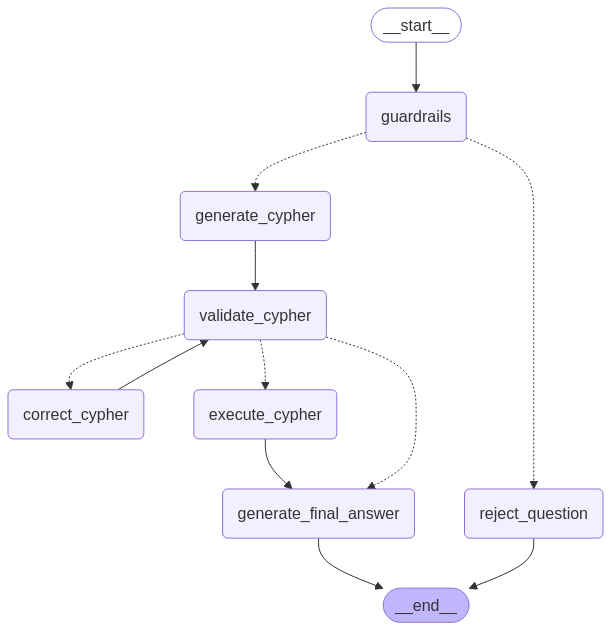

In [15]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph

langgraph = StateGraph(OverallState, input=InputState, output=OutputState)
langgraph.add_node(guardrails)
langgraph.add_node(generate_cypher)
langgraph.add_node("reject_question", reject_question)
langgraph.add_node(validate_cypher)
langgraph.add_node(correct_cypher)
langgraph.add_node(execute_cypher)
langgraph.add_node(generate_final_answer)

langgraph.add_edge(START, "guardrails")
langgraph.add_conditional_edges(
    "guardrails",
    guardrails_condition,
)
langgraph.add_edge("generate_cypher", "validate_cypher")
langgraph.add_conditional_edges(
    "validate_cypher",
    validate_cypher_condition,
)
langgraph.add_edge("execute_cypher", "generate_final_answer")
langgraph.add_edge("correct_cypher", "validate_cypher")
langgraph.add_edge("generate_final_answer", END)
langgraph.add_edge("reject_question", END)


langgraph = langgraph.compile()

# View
display(Image(langgraph.get_graph().draw_mermaid_png()))

We can now test the application by asking an irrelevant question.

In [65]:
langgraph.invoke({"question": "What was the cast of the Casino?"})

{'answer': "Sorry, I can't answer questions unrelated to genes, drugs, or their targets.",
 'steps': ['guardrail', 'guardrail', 'rejected'],
 'cypher_statement': ''}

In [101]:
langgraph.invoke({"question": "Find the top 10 drugs with activity at the same target as CETIRIZINE"})

Cypher to run: MATCH (cet:MOLECULE {Name: 'CETIRIZINE'})-[r1:chemblDrugToTarget|cancer_biomarkersDrugToTarget]->(t:TARGET)<-[r2:chemblDrugToTarget|cancer_biomarkersDrugToTarget]-(top10:MOLECULE) 
WHERE cet <> top10 
WITH t, top10, r2.score AS ActivityScore 
ORDER BY ActivityScore DESC 
LIMIT 10 
RETURN top10.Name AS Drug, t.Name AS Target, ActivityScore


{'answer': 'The top 10 drugs with activity at the same target as CETIRIZINE, which is the histamine receptor H1, are FEXOFENADINE, RUPATADINE, AZATADINE, MIZOLASTINE, ORPHENADRINE, HISTAMINE, HYDROXYZINE, CARBINOXAMINE, TRIPROLIDINE, and LORATADINE.',
 'steps': ['guardrail',
  'generate_cypher',
  'validate_cypher',
  'execute_cypher',
  'generate_final_answer'],
 'cypher_statement': "MATCH (cet:MOLECULE {Name: 'CETIRIZINE'})-[r1:chemblDrugToTarget|cancer_biomarkersDrugToTarget]->(t:TARGET)<-[r2:chemblDrugToTarget|cancer_biomarkersDrugToTarget]-(top10:MOLECULE) \nWHERE cet <> top10 \nWITH t, top10, r2.score AS ActivityScore \nORDER BY ActivityScore DESC \nLIMIT 10 \nRETURN top10.Name AS Drug, t.Name AS Target, ActivityScore"}

In [ ]:
def pretty_print_answer(answer_dict):
    from IPython.display import Markdown, display
    
    answer = answer_dict.get("answer", "")
    answer_md = answer.replace('\n', '  \n') 
    display(Markdown(answer_md))


In [18]:
pretty_print_answer(langgraph.invoke({"question": "Find the top 10 most similar drugs to Cetirizine"}))

Cypher to run: MATCH (ref:MOLECULE {Name: 'CETIRIZINE'}) CALL db.index.vector.queryNodes('molEmbed', 10, ref.embedding) YIELD node AS molecule, score RETURN molecule.Name AS Drug, score AS Similarity ORDER BY Similarity DESC LIMIT 10


The top 10 most similar drugs to Cetirizine are:  
  
1. Levocetirizine  
2. Cetirizine  
3. Levocetirizine Dihydrochloride  
4. Cetirizine Hydrochloride  
5. Bepotastine  
6. Pipamperone  
7. Axelopran  
8. Vilanterol  
9. Efinaconazole  
10. Mefenamic Acid

In [19]:
pretty_print_answer(langgraph.invoke({"question": "Find the top 10 drugs with activity at the same target as CETIRIZINE, then identify 5 similar drugs to each of those 10"}))

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: CALL subquery without a variable scope clause is now deprecated. Use CALL (top10) { ... }} {position: line: 6, column: 1, offset: 290} for query: "EXPLAIN MATCH (cet:MOLECULE {Name: 'CETIRIZINE'})-[r1:chemblDrugToTarget|cancer_biomarkersDrugToTarget]->(t:TARGET)<-[r2:chemblDrugToTarget|cancer_biomarkersDrugToTarget]-(top10:MOLECULE) \nWHERE cet <> top10 \nWITH t, top10, r2.score AS ActivityScore \nORDER BY ActivityScore DESC \nLIMIT 10 \nCALL { \n  WITH top10 \n  CALL db.index.vector.queryNodes('molEmbed', 5, top10.embedding) \n  YIELD node AS similar, score \n  RETURN similar.Name AS Similar_Drug, score AS Similarity \n} \nRETURN top10.Name AS Original_Drug, t.Name AS Target, ActivityScore, collect(Similar_Drug) AS Similar_Drugs"
Received notificat

Cypher to run: MATCH (cet:MOLECULE {Name: 'CETIRIZINE'})-[r1:chemblDrugToTarget|cancer_biomarkersDrugToTarget]->(t:TARGET)<-[r2:chemblDrugToTarget|cancer_biomarkersDrugToTarget]-(top10:MOLECULE) 
WHERE cet <> top10 
WITH t, top10, r2.score AS ActivityScore 
ORDER BY ActivityScore DESC 
LIMIT 10 
CALL { 
  WITH top10 
  CALL db.index.vector.queryNodes('molEmbed', 5, top10.embedding) 
  YIELD node AS similar, score 
  RETURN similar.Name AS Similar_Drug, score AS Similarity 
} 
RETURN top10.Name AS Original_Drug, t.Name AS Target, ActivityScore, collect(Similar_Drug) AS Similar_Drugs


The top 10 drugs with activity at the same target (histamine receptor H1) as CETIRIZINE are:  
  
1. FEXOFENADINE  
   - Similar drugs: FEXOFENADINE, FEXOFENADINE HYDROCHLORIDE, HALOPERIDOL LACTATE, BENACTYZINE, TROSPIUM  
  
2. RUPATADINE  
   - Similar drugs: RUPATADINE, DESLORATADINE, CHLOROQUINE HYDROCHLORIDE, CHLOROQUINE, HYDROXYCHLOROQUINE  
  
3. AZATADINE  
   - Similar drugs: AZATADINE, DESLORATADINE, MIANSERIN, BROMPERIDOL, HALOPERIDOL  
  
4. MIZOLASTINE  
   - Similar drugs: MIZOLASTINE, CHEMBL3526617, CHEMBL3526476, SAR-260301, RIVOCERANIB  
  
5. ORPHENADRINE  
   - Similar drugs: ORPHENADRINE, DIPHENHYDRAMINE HYDROCHLORIDE, DIPHENHYDRAMINE METHYLBROMIDE, DIPHENHYDRAMINE, DIPHENYLPYRALINE HYDROCHLORIDE  
  
6. HISTAMINE  
   - Similar drugs: BETAZOLE, CALYSTEGINE B2, CHEMBL1230309, CHEMBL1235255, CHEMBL1232586  
  
7. HYDROXYZINE  
   - Similar drugs: HYDROXYZINE, HYDROXYZINE HYDROCHLORIDE, BIPERIDEN, MK-0812, DOXAPRAM  
  
8. CARBINOXAMINE  
   - Similar drugs: CARBINOXAMINE, PHENIRAMINE, LEVOPROPOXYPHENE, PROPOXYPHENE, DA-8031  
  
9. TRIPROLIDINE  
   - Similar drugs: TRIPROLIDINE, METYRAPONE, CLEMASTINE FUMARATE, CHEMBL3041160, SUPROFEN  
  
10. LORATADINE  
    - Similar drugs: LORATADINE, FENPIPRANE, DEMEXIPTILINE, TANESPIMYCIN, CHEMBL1083185